In [58]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import datetime
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [59]:
total_labels = pd.read_csv('./input/dengue_labels_train.csv')
total_features = pd.read_csv('./input/dengue_features_train.csv')
total_test_features = pd.read_csv('./input/dengue_features_test.csv')
total_features = total_features.drop(total_features.index[[1456]], axis=0) 
total_labels = total_labels.drop(total_labels.columns[[0, 1, 2]], axis=1) 

In [60]:
def preprocess_data(data_path, labels_path):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [61]:
sj_train, iq_train = preprocess_data('./input/dengue_features_train.csv',
                                    './input/dengue_labels_train.csv')

In [62]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [72]:
for title in sj_train.columns.tolist()[:3]:
    sj_train[title] = normalize(sj_train[title])
    iq_train[title] = normalize(iq_train[title])
    sj_train_subtest[title] = normalize(sj_train_subtest[title])
    iq_train_subtest[title] = normalize(iq_train_subtest[title])

/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [73]:
sj_train['new_feature'] = multiply(sj_train['reanalysis_specific_humidity_g_per_kg'], sj_train['reanalysis_dew_point_temp_k'], sj_train['station_avg_temp_c'])
iq_train['new_feature'] = multiply(iq_train['reanalysis_specific_humidity_g_per_kg'], iq_train['reanalysis_dew_point_temp_k'], iq_train['station_avg_temp_c'])
sj_train_subtest['new_feature'] = multiply(sj_train_subtest['reanalysis_specific_humidity_g_per_kg'], sj_train_subtest['reanalysis_dew_point_temp_k'], sj_train_subtest['station_avg_temp_c'])
iq_train_subtest['new_feature'] = multiply(iq_train_subtest['reanalysis_specific_humidity_g_per_kg'], iq_train_subtest['reanalysis_dew_point_temp_k'], iq_train_subtest['station_avg_temp_c'])

/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Simran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [74]:
iq_train.columns.tolist()

['reanalysis_specific_humidity_g_per_kg',
 'reanalysis_dew_point_temp_k',
 'station_avg_temp_c',
 'station_min_temp_c',
 'total_cases',
 'new_feature']

In [75]:
def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "new_feature + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)
        
        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

PatsyError: Error evaluating factor: NameError: name 'new_feature' is not defined
    total_cases ~ 1 + reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + station_min_temp_c + new_feature + station_avg_temp_c
                                                                                                                 ^^^^^^^^^^^

In [36]:
sj_test, iq_test = preprocess_data('./input/dengue_features_test.csv', None)

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv('./input/submission_format.csv',
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("./input/bench_submission.csv")

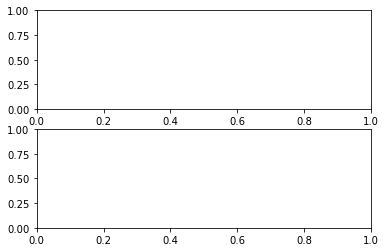

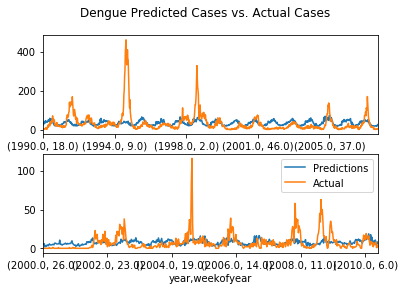

In [16]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()
plt.show()

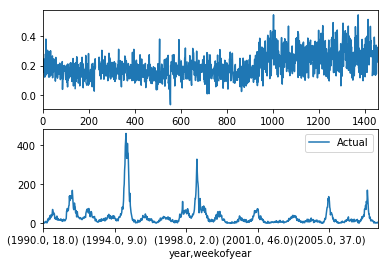

In [17]:
figs, axes = plt.subplots(nrows=2, ncols=1)
# station_diur_temp_rng_c, 
# plot sj
# print(sj_train['reanalysis_specific_humidity_g_per_kg'])

total_features.ndvi_sw.plot(ax=axes[0], label="...")

# sj_train.total_cases.plot(ax=axes[0], label="Actual")
# print(dir(sj_train))

sj_train.total_cases.plot(ax=axes[1], label="Actual")

# plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()
plt.show()

In [18]:
def normalize(column):
    new_column = []
    min_val = min(column)
    max_val = max(column)
    range_val = max_val-min_val
    for entry in column:
        new_column.append((entry-min_val)/range_val)
    return new_column

In [51]:
def multiply(column1, column2, column3):
    new_column = []
    for index in range(len(column1)):
        next_entry = column1[index]*column2[index]
#         if column3:
        next_entry = next_entry*column3[index]
        new_column.append(next_entry)
    return new_column